In [1]:
import rpy2.robjects as robjects

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import os
os.environ['R_HOME'] = '/home/kxxiao/anaconda3/envs/sg/lib/R'
os.environ['R_USER'] = '/home/kxxiao/anaconda3/envs/sg/lib/python3.6/site-packages/rpy2'

In [4]:
import h5py
import pandas as pd
import numpy as np
import scanpy as sc
import STAGATE
import matplotlib.pyplot as plt
import os
import sys

import tensorflow as tf
tf.compat.v1.disable_eager_execution()

import automatic_peak_picking_2D
from automatic_peak_picking_2D import automatic_2D_peak_picking

In [22]:
f = h5py.File('../example_datasets/pig_2D.h5', 'r')
data=pd.DataFrame((f['data']))

mass=np.array(f['mass']).reshape(-1,)
spatial=np.array(f['spatial'])

adata=sc.AnnData(data)
adata.obsm["spatial"]=spatial

adata.var_names=mass.astype(str)

In [17]:
adata.var_names_make_unique()


In [7]:
? automatic_2D_peak_picking

ifpicking= 1
---Begin to automatic peak picking!-----
First iter begin!
------Calculating spatial graph...
The graph contains 38736 edges, 4959 cells.
7.8113 neighbors per cell on average.
Size of Input:  (4959, 10200)
------Pre-clustering using louvain with resolution=0.10
------Pruning the graph...
38736 edges before pruning.
34806 edges after pruning.


100%|██████████| 1000/1000 [09:21<00:00,  1.78it/s]
R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 5.4.10
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%
------Calculating spatial graph...
The graph contains 38736 edges, 4959 cells.
7.8113 neighbors per cell on average.
Size of Input:  (4959, 4822)
------Pre-clustering using louvain with resolution=0.10
------Pruning the graph...
38736 edges before pruning.
34690 edges after pruning.


100%|██████████| 1000/1000 [04:23<00:00,  3.80it/s]


fitting ...
  |======================================================================| 100%


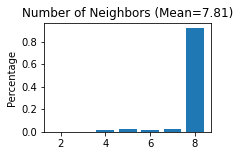

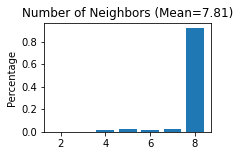

In [23]:
adata2=automatic_2D_peak_picking(adata,10200,num_marker=1250,cluster_method='mclust',r=1.7,
                                 k_class_first=5,k_class=10,alpha=0.1,pre_resolutation=0.1)

In [24]:
adata2

AnnData object with n_obs × n_vars = 4959 × 4822
    obs: 'expression_louvain_label', 'mclust'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'Spatial_Net', 'pca', 'neighbors', 'louvain', 'rank_genes_groups'
    obsm: 'spatial', 'X_pca', 'STAGATE'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [25]:
adata2.uns["mclust_colors"]=['#1f77b4','#d62728','#17becf','#aa40fc','#ff7f0e',
'#b5bd61','#279e68','#8c564b','#aec7e8','#e377c2',]

<AxesSubplot:title={'center':'SmartGate'}, xlabel='spatial1', ylabel='spatial2'>

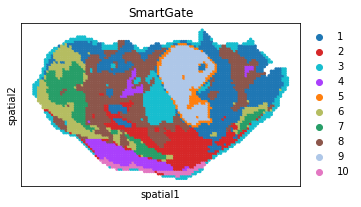

In [26]:
plt.rcParams["figure.figsize"] = (5, 3)

sc.pl.embedding(adata2, basis='spatial',color='mclust',show=False,title='SmartGate',s=44)

In [59]:
np.unique(adata.obs['mclust'])

array([1, 2, 3, 4, 5])

In [64]:
adata2.obs['mclust']=adata2.obs['mclust'].astype(str)

<AxesSubplot:title={'center':'Heart'}, xlabel='spatial1', ylabel='spatial2'>

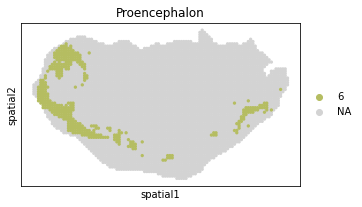

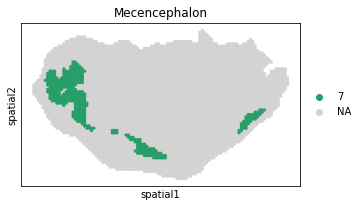

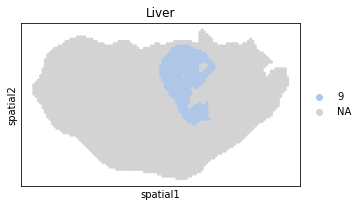

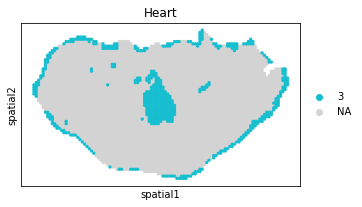

In [66]:
#for i in range(np.unique(adata.ons['mclust'])):
sc.pl.embedding(adata2, basis='spatial',color='mclust',show=False,title='Proencephalon',s=44,groups=['6'])
sc.pl.embedding(adata2, basis='spatial',color='mclust',show=False,title='Mecencephalon',s=44,groups=['7'])
sc.pl.embedding(adata2, basis='spatial',color='mclust',show=False,title='Liver',s=44,groups=['9'])
sc.pl.embedding(adata2, basis='spatial',color='mclust',show=False,title='Heart',s=44,groups=['3'])
#sc.pl.embedding(adata2, basis='spatial',color='mclust',show=False,title='SmartGate',s=44,groups=['6'])

In [28]:
pd.DataFrame(adata2.uns['rank_genes_groups']['names']).head(5)

,1,2,3,4,5,6,7,8,9,10
0,309.6667,182.3333,187.1667,153.0833,281.5833,838.6667,810.5834,261.5,535.5,269.25
1,307.6667,166.4167,214.0,153.1667,253.5,840.5834,810.5,264.4167,537.5,270.25
2,307.5833,182.4167,187.25,151.0833,327.25,838.5834,810.3334,263.5,535.4167,271.25
3,309.75,166.3333,214.0833,153.25,253.5833,840.6667,810.4167,487.5833,509.5,270.1667
4,309.5833,166.5,187.0833,151.1667,281.5,838.5,303.75,261.4167,537.4167,269.3333


In [51]:
adata_norm=adata2.copy()
norm_X=pd.DataFrame(adata_norm.X)
norm_X=(norm_X-np.min(norm_X))/(np.max(norm_X)-np.min(norm_X))
# _range = np.max(data) - np.min(data)
adata_norm.X=norm_X

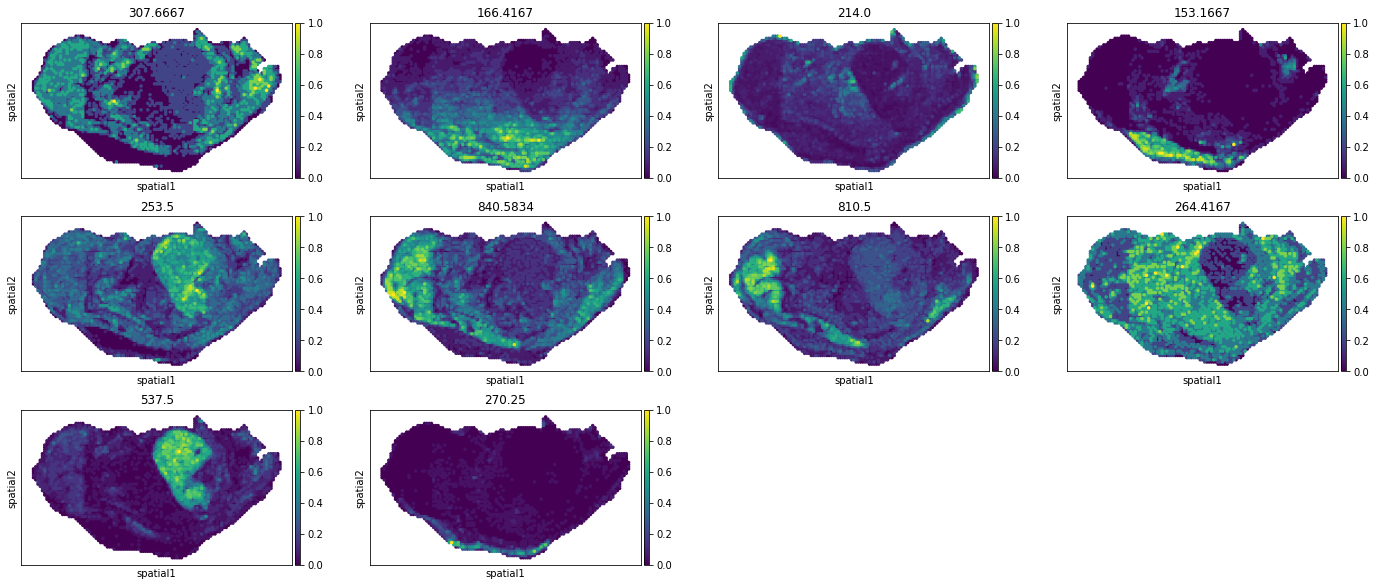

In [52]:
sc.pl.embedding(adata_norm, basis="spatial",color=adata2.uns['rank_genes_groups']['names'][1],
                s=50)

In [53]:
marker_ion=pd.DataFrame(adata2.uns['rank_genes_groups']['names']).head(2)
marker_ion=np.array(marker_ion).reshape(-1,)

In [54]:
sc.tl.rank_genes_groups(adata2, 'mclust', method='t-test')

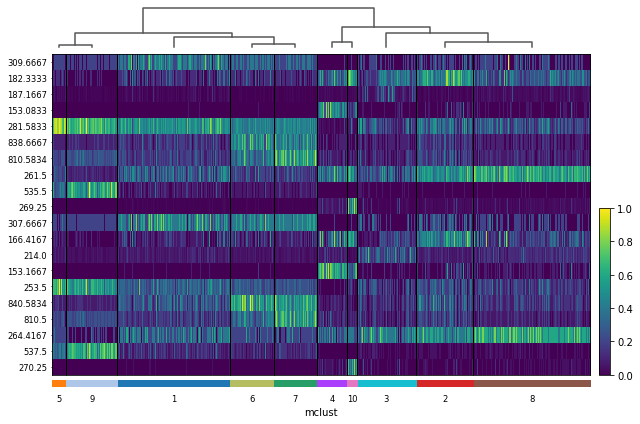

In [56]:
sc.pl.heatmap(adata_norm,marker_ion,groupby='mclust',dendrogram=True,
              swap_axes=True,figsize=[10,7])